In [1]:
# Import necessary libraries and modules
import clip  # OpenAI's CLIP library for image and text matching
import torch  # PyTorch for deep learning
from PIL import Image  # Python Imaging Library for image processing
import pandas as pd  # Pandas for data manipulation and analysis
import numpy as np  # NumPy for numerical operations
from sklearn.model_selection import train_test_split  # scikit-learn for splitting data into training and testing sets

# Note: Make sure to install the required libraries if not already installed.
# You can use the following commands to install them:
# pip install torch torchvision
# pip install openai clip
# pip install pillow
# pip install pandas
# pip install scikit-learn

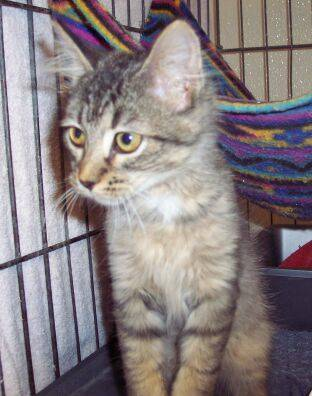

In [2]:
file_path = './cat_dog1/cat.2.jpg'

img = Image.open(file_path)

display(img)
#Meow

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu" # Runs the program using GPU if there is any
model, transform = clip.load("ViT-B/32", device) # Loading the CLIP model (Contrastive Language-Image Pretraining)
# We selected Model ViT-B/32 which is a Vision Transformer, we selected it particularly because it got the most parameters from all other architectures

In [28]:
# Load your dataset from the CSV file into df
csv_path = "./cat_dog1.csv" 
df = pd.read_csv(csv_path)

In [31]:
# Split the dataset into training and testing sets
train_df, test_df = train_test_split(df, test_size=0.2)

In [32]:
train_df

,Unnamed: 0,image,labels
1789,1789,dog.48.jpg,1
1399,1399,cat.869.jpg,0
1883,1883,cat.597.jpg,0
23,23,dog.332.jpg,1
1600,1600,dog.3.jpg,1
...,...,...,...
1484,1484,cat.59.jpg,0
91,91,cat.685.jpg,0
474,474,cat.748.jpg,0
1211,1211,dog.918.jpg,1


In [33]:
# Looking at the dataset
test_df

,Unnamed: 0,image,labels
503,503,dog.27.jpg,1
750,750,dog.134.jpg,1
407,407,dog.239.jpg,1
484,484,dog.268.jpg,1
542,542,cat.45.jpg,0
...,...,...,...
918,918,dog.774.jpg,1
1805,1805,cat.588.jpg,0
1395,1395,cat.178.jpg,0
274,274,dog.516.jpg,1


In [35]:
# Function to get CLIP embeddings for a given image path
def get_clip_embedding(image_path):
    # Open the image file and transform it using the pre-defined 'transform' function
    # transform: Image PreProcessing, ensure that the input image conform to the model's requirements
    # unsqueeze: It chenges the output from transform to batch dimension
    # to(device): Specifies moving the model to the device we declared upove (CPU or GPU)
    image = transform(Image.open(image_path)).unsqueeze(0).to(device)
    # print(transform(Image.open(image_path)).shape)
    # print(transform(Image.open(image_path)).unsqueeze(0).shape)
    # Ensure no gradient computation is performed during the inference (Cause we had a error without it)
    with torch.no_grad():
        # Encode the image using the CLIP model and convert the result to a NumPy array
        # model.encode: returns the image embeddings
        return model.encode_image(image).detach().numpy()

In [36]:
# Testing that it works
# By getting embeddings for 1 image and seeing the features returned from the embedding
test = './cat_dog1/cat.2.jpg'
test = get_clip_embedding(test)
print(test.shape)

(1, 512)


In [37]:
# Extract CLIP embeddings for all images in the training set
train_embeddings = np.vstack([get_clip_embedding('./cat_dog1/' + image_path) for image_path in train_df["image"]])

In [38]:
# Extract CLIP embeddings for all images in the testing set
test_embeddings = np.vstack([get_clip_embedding('./cat_dog1/' + image_path) for image_path in test_df["image"]])

Using Fishers Algorithm for predections

In [40]:
TrainDogs = train_embeddings[train_df['labels'] == 1] # Filtering training dataset to dogs class
TrainCats = train_embeddings[train_df['labels'] == 0] # Filtering training dataset to cats class

print(TrainDogs.shape) #Seeing how many dogs were filtered
print(TrainCats.shape) #Seeing how many cats were filtered

meanDogs = np.mean(TrainDogs, axis=0) #Getting the mean for all dogs embeddings
meanCats = np.mean(TrainCats, axis=0) #Getting the mean for all cats embeddings

#Checking that it is with the right shape
print("Mean Dogs:", meanDogs.reshape(-1,1).shape)
print("Mean Cats:", meanCats.reshape(-1,1).shape)

(812, 512)
(788, 512)
Mean Dogs: (512, 1)
Mean Cats: (512, 1)


In [41]:
# SW = Sw1 + Sw2
# Sw1 = sum((dogs-dogsMean)^2) (Dogs Variance)
# Sw2 = sum((cats-catsMean)^2) (Cats Variance)
Sw = np.cov(TrainDogs, rowvar=False) + np.cov(TrainCats, rowvar=False)

print('SW:', Sw)
# Calculating the wieght
# W = C * inverse(SW) * (CatsMean - DogMean)
# In this case, C = 0.1
w = 0.1 * np.linalg.inv(Sw).dot(meanCats.reshape(-1,1) - meanDogs.reshape(-1,1))

print(w)

SW: [[ 9.53356663e-02  2.22583904e-02  8.64442364e-03 ... -1.54407345e-02
   2.17345899e-03  1.44158773e-03]
 [ 2.22583904e-02  8.95957130e-02  1.15099079e-02 ... -2.68104015e-03
  -8.88293673e-06 -9.21172158e-04]
 [ 8.64442364e-03  1.15099079e-02  6.16273760e-02 ... -1.29467754e-03
  -4.01498728e-03  8.16522038e-04]
 ...
 [-1.54407345e-02 -2.68104015e-03 -1.29467754e-03 ...  1.68504494e-01
  -4.60323003e-03  1.48498851e-02]
 [ 2.17345899e-03 -8.88293673e-06 -4.01498728e-03 ... -4.60323003e-03
   6.61105361e-02 -4.79007798e-04]
 [ 1.44158773e-03 -9.21172158e-04  8.16522038e-04 ...  1.48498851e-02
  -4.79007798e-04  7.28240688e-02]]
[[-1.95254776e+00]
 [-4.75838409e-01]
 [ 1.29010937e+00]
 [ 4.64408754e-01]
 [ 2.77001844e-01]
 [-3.32570335e-01]
 [ 9.44583964e-01]
 [ 2.77472407e+00]
 [-9.16575041e-01]
 [-1.29403771e+00]
 [ 1.38335348e+00]
 [-1.86503493e+00]
 [ 2.88421618e-01]
 [ 5.47262034e-01]
 [ 3.13394899e-02]
 [ 4.10211603e-01]
 [ 1.58875054e+00]
 [ 9.12636096e-01]
 [-6.69708893e-01]

In [42]:
#Importing accuracy metrics
#Importing Plotting libraries too
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

In [43]:
# Apply the Fisher's linear discriminant to the test set
test_predictions = test_embeddings.dot(w)
print(test_predictions)

[[-5.91949270e+00]
 [-6.51687469e+00]
 [-6.18498069e+00]
 [-5.41791238e+00]
 [ 1.71172831e+01]
 [ 1.56377606e+01]
 [-6.84091860e+00]
 [ 1.79691917e+01]
 [-7.12868239e+00]
 [ 2.01856667e+01]
 [ 1.73804810e+01]
 [-2.89389300e+00]
 [ 1.83455212e+01]
 [ 2.01788708e+01]
 [-6.79615516e+00]
 [-3.27856818e+00]
 [-5.25552789e+00]
 [ 9.29343486e+00]
 [ 1.90280384e+01]
 [-5.90771892e+00]
 [ 1.86886864e+01]
 [ 1.71728220e+01]
 [-4.77068090e+00]
 [ 1.86528739e+01]
 [ 1.71441251e+01]
 [-5.57133300e+00]
 [ 1.80423209e+01]
 [-5.35370369e+00]
 [ 1.84097270e+01]
 [ 1.78417477e+01]
 [ 1.61895320e+01]
 [ 1.71992281e+01]
 [-1.07905945e+01]
 [ 1.85606685e+01]
 [ 1.82129460e+01]
 [-7.97841405e+00]
 [-5.20852361e+00]
 [-7.66148537e+00]
 [ 1.82071463e+01]
 [-6.69120048e+00]
 [ 1.91533123e+01]
 [ 1.77251230e+01]
 [-7.19024158e+00]
 [-9.59789418e+00]
 [ 1.77297688e+01]
 [-5.86912764e+00]
 [ 1.99048008e+01]
 [ 1.94859597e+01]
 [-5.61277230e+00]
 [-6.48431462e+00]
 [-3.90147628e+00]
 [-7.19076031e+00]
 [ 1.8996398

In [44]:
# Classifing the postive numbers to be dogs and negative to be cats
tests = test_predictions > 0
tests

array([[False],
       [False],
       [False],
       [False],
       [ True],
       [ True],
       [False],
       [ True],
       [False],
       [ True],
       [ True],
       [False],
       [ True],
       [ True],
       [False],
       [False],
       [False],
       [ True],
       [ True],
       [False],
       [ True],
       [ True],
       [False],
       [ True],
       [ True],
       [False],
       [ True],
       [False],
       [ True],
       [ True],
       [ True],
       [ True],
       [False],
       [ True],
       [ True],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [ True],
       [ True],
       [False],
       [False],
       [ True],
       [False],
       [ True],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [ True],
       [ True],
       [False],
       [ True],
       [ True],
       [ True],
       [False],
       [ True],
       [False],
       [

Accuracy: 0.99
Precision: 1.00
Recall: 0.98
F1 Score: 0.99


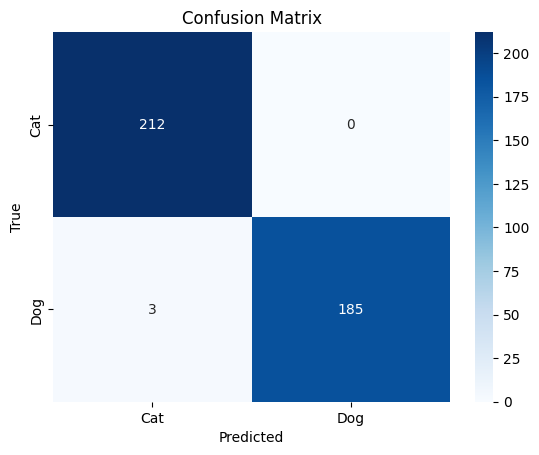

In [45]:
# Threshold predictions
threshold = 0  # Setting the threshold for any postive number to be a class, and negative numbers to be the other class, like the previous code block
test_predictions_binary = (test_predictions < threshold).astype(int)

# Calculate metrics
accuracy = accuracy_score(test_df["labels"], test_predictions_binary)
precision = precision_score(test_df["labels"], test_predictions_binary)
recall = recall_score(test_df["labels"], test_predictions_binary)
f1 = f1_score(test_df["labels"], test_predictions_binary)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

# Confusion matrix
conf_mat = confusion_matrix(test_df["labels"], test_predictions_binary)

# Visualize confusion matrix
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=["Cat", "Dog"], yticklabels=["Cat", "Dog"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [46]:
# Apply the Fisher's linear discriminant to the train set
train_predictions = train_embeddings.dot(w)
print(train_predictions)

[[-4.74166525]
 [17.03066227]
 [18.15226645]
 ...
 [19.33964797]
 [-6.34643645]
 [18.04155872]]


Accuracy: 1.00
Precision: 1.00
Recall: 1.00
F1 Score: 1.00


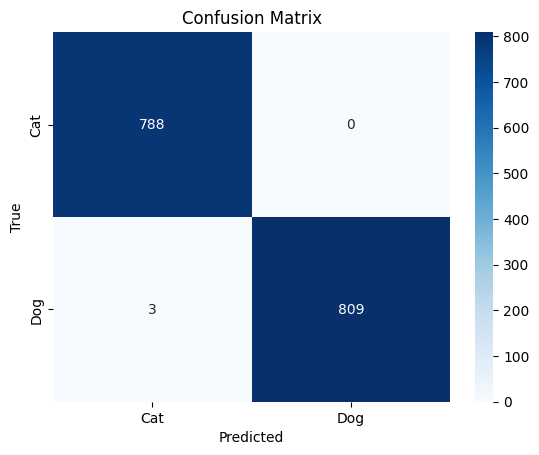

In [47]:

# Threshold predictions
threshold = 0  # You can adjust this threshold
train_predictions_binary = (train_predictions < threshold).astype(int)

# Calculate metrics
accuracy = accuracy_score(train_df["labels"], train_predictions_binary)
precision = precision_score(train_df["labels"], train_predictions_binary)
recall = recall_score(train_df["labels"], train_predictions_binary)
f1 = f1_score(train_df["labels"], train_predictions_binary)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

# Confusion matrix
conf_mat = confusion_matrix(train_df["labels"], train_predictions_binary)

# Visualize confusion matrix
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=["Cat", "Dog"], yticklabels=["Cat", "Dog"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

Bonus

In [68]:
w1 = 10000000000000 * np.linalg.inv(Sw).dot(meanCats.reshape(-1,1) - meanDogs.reshape(-1,1))
w2 = 0.000000000001 * np.linalg.inv(Sw).dot(meanCats.reshape(-1,1) - meanDogs.reshape(-1,1))
test_predictions1 = test_embeddings.dot(w1)
test_predictions2 = test_embeddings.dot(w2)

Accuracy: 0.99
Precision: 1.00
Recall: 0.98
F1 Score: 0.99


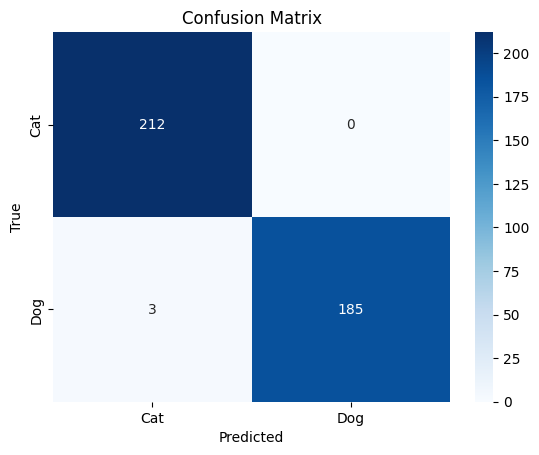

In [69]:
# Threshold predictions
threshold = 0  # Setting the threshold for any postive number to be a class, and negative numbers to be the other class, like the previous code block
test_predictions_binary = (test_predictions1 < threshold).astype(int)

# Calculate metrics
accuracy = accuracy_score(test_df["labels"], test_predictions_binary)
precision = precision_score(test_df["labels"], test_predictions_binary)
recall = recall_score(test_df["labels"], test_predictions_binary)
f1 = f1_score(test_df["labels"], test_predictions_binary)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

# Confusion matrix
conf_mat = confusion_matrix(test_df["labels"], test_predictions_binary)

# Visualize confusion matrix
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=["Cat", "Dog"], yticklabels=["Cat", "Dog"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

Accuracy: 0.99
Precision: 1.00
Recall: 0.98
F1 Score: 0.99


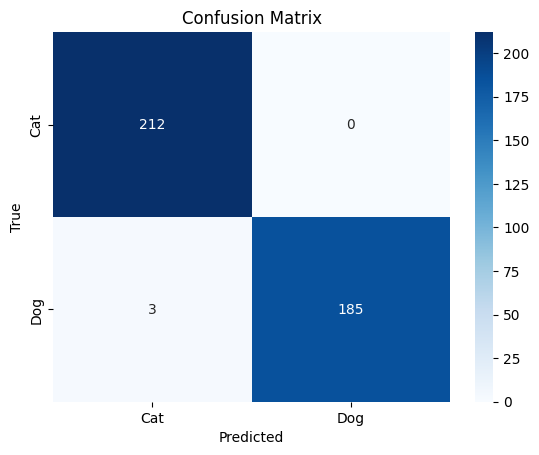

In [70]:
# Threshold predictions
threshold = 0  # Setting the threshold for any postive number to be a class, and negative numbers to be the other class, like the previous code block
test_predictions_binary = (test_predictions2 < threshold).astype(int)

# Calculate metrics
accuracy = accuracy_score(test_df["labels"], test_predictions_binary)
precision = precision_score(test_df["labels"], test_predictions_binary)
recall = recall_score(test_df["labels"], test_predictions_binary)
f1 = f1_score(test_df["labels"], test_predictions_binary)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

# Confusion matrix
conf_mat = confusion_matrix(test_df["labels"], test_predictions_binary)

# Visualize confusion matrix
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=["Cat", "Dog"], yticklabels=["Cat", "Dog"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()